In [1]:
import pandas as pd
import datetime
import os
import sys
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data for covid cases
daily_cases = pd.read_csv("us-counties.csv")
# treatment - NY
daily_cases_NY = daily_cases[daily_cases["state"] == "New York"]
# control - PA,MA,MD
daily_cases_PA = daily_cases[daily_cases["state"] == "Pennsylvania"]
daily_cases_MA = daily_cases[daily_cases["state"] == "Massachusetts"]
daily_cases_MD = daily_cases[daily_cases["state"] == "Maryland"]

# load population data
pop =  pd.read_excel("co-est2019-annres.xlsx",  header=[0,1,2,3])
pop.columns = pop.columns.droplevel([0,1,2])
pop.rename(columns={"Unnamed: 0_level_3": "Geographic Area"}, inplace = True)
pop["Geographic Area"] = pop["Geographic Area"].str.replace('.','', regex=True)

In [3]:
# subset population data to NY
pop_NY = pop[pop['Geographic Area'].str.contains("New York")]
# use 2019 population
pop_NY = pop_NY.iloc[:, [0] + [-1]]
# rename county column
pop_NY['Geographic Area'] = pop_NY['Geographic Area'].str.replace(' County, New York', '')
# rename dataframe columnes
pop_NY.columns = ['County', 'population']

# subset population data to PA
pop_PA = pop[pop['Geographic Area'].str.contains(", Pennsylvania")]
pop_PA = pop_PA.iloc[:-1]
# use 2019 population
pop_PA = pop_PA.iloc[:, [0] + [-1]]
# rename county column
pop_PA['Geographic Area'] = pop_PA['Geographic Area'].str.replace(' County, Pennsylvania', '')
pop_PA['Geographic Area'] = pop_PA['Geographic Area'].str.replace(', Pennsylvania', '')
# rename dataframe columnes
pop_PA.columns = ['County', 'population']

# subset population data to MA
pop_MA = pop[pop['Geographic Area'].str.contains("Massachusetts")]
# use 2019 population
pop_MA = pop_MA.iloc[:, [0] + [-1]]
# rename county column
pop_MA['Geographic Area'] = pop_MA['Geographic Area'].str.replace(' County, Massachusetts', '')
# rename dataframe columnes
pop_MA.columns = ['County', 'population']

# subset population data to MD
pop_MD = pop[pop['Geographic Area'].str.contains("Maryland")]
# use 2019 population
pop_MD = pop_MD.iloc[:, [0] + [-1]]
# rename county column
pop_MD['Geographic Area'] = pop_MD['Geographic Area'].str.replace(' County, Maryland', '')
# rename dataframe columnes
pop_MD.columns = ['County', 'population']


In [4]:
# remove uknown counties
daily_cases_NY = daily_cases_NY[daily_cases_NY['county']!='Unknown']
daily_cases_PA = daily_cases_PA[daily_cases_PA['county']!='Unknown']
daily_cases_MA = daily_cases_MA[daily_cases_MA['county']!='Unknown']
daily_cases_MD = daily_cases_MD[daily_cases_MD['county']!='Unknown']


In [5]:
# set comparison period to be 21 days
numdays = 21

# retrieve policy date for NY Stay at Home Order
policy_ny = datetime.datetime.strptime('21032020', "%d%m%Y").date()
date_before_ny = [policy_ny - datetime.timedelta(days=x) for x in range(numdays+1)]
date_after_ny = [policy_ny + datetime.timedelta(days=x) for x in range(numdays+1)]
date_list_ny = date_before_ny + date_after_ny


In [6]:
# data cleaning - treatment state: NY
daily_ny = daily_cases_NY.copy()
daily_ny["date"] = pd.to_datetime(daily_ny["date"])
daily_ny_timed = daily_ny.loc[daily_ny["date"].isin(date_list_ny)] # covering a total of 43 days (21 + 21 + 1)
pop = pop_NY[pop_NY["County"] == "Bronx"]['population'].values[0] +pop_NY[pop_NY["County"] == "Kings"]['population'].values[0]+pop_NY[pop_NY["County"] == "New York"]['population'].values[0]+pop_NY[pop_NY["County"] == "Queens"]['population'].values[0]+pop_NY[pop_NY["County"] == "Richmond"]['population'].values[0]
pop_NY.loc[len(pop_NY.index)] = ['New York City', pop] 
pop_NY.loc[pop_NY["County"]=='St Lawrence',"County"] = "St. Lawrence"
# merge NY population with COVID cases
merged_NY = pd.merge(left=daily_ny_timed, right=pop_NY, how='left', left_on='county', right_on='County')
# drop duplicated NY County column
merged_NY = merged_NY.drop('County', axis=1)
# create NY standardized COVID cases column
merged_NY['cases_standardized'] = merged_NY['cases']/merged_NY['population']*10000

# create indicator variable - pre and post policy annoucement
merged_NY['post_policy'] = (merged_NY.date > '2020-03-21')

In [7]:
# data cleaning - treatment state: PA
daily_pa = daily_cases_PA.copy()
daily_pa["date"] = pd.to_datetime(daily_pa["date"])
daily_pa_timed = daily_pa.loc[daily_pa["date"].isin(date_list_ny)] # covering a total of 43 days (21 + 21 + 1)
# merge PA population with COVID cases
merged_PA = pd.merge(left=daily_pa_timed, right=pop_PA, how='left', left_on='county', right_on='County')
# drop duplicated PA County column
merged_PA = merged_PA.drop('County', axis=1)
# create PA standardized COVID cases column
merged_PA['cases_standardized'] = merged_PA['cases']/merged_PA['population']*10000

# create indicator variable - pre and post policy annoucement
merged_PA['post_policy'] = (merged_PA.date > '2020-03-21')

In [8]:
# data cleaning - treatment state: MA
daily_ma = daily_cases_MA.copy()
daily_ma["date"] = pd.to_datetime(daily_ma["date"])
daily_ma_timed = daily_ma.loc[daily_ma["date"].isin(date_list_ny)] # covering a total of 43 days (21 + 21 + 1)
# merge MA population with COVID cases
merged_MA = pd.merge(left=daily_ma_timed, right=pop_MA, how='left', left_on='county', right_on='County')
# drop duplicated MA County column
merged_MA = merged_MA.drop('County', axis=1)
# create MA standardized COVID cases column
merged_MA['cases_standardized'] = merged_MA['cases']/merged_MA['population']*10000

# create indicator variable - pre and post policy annoucement
merged_MA['post_policy'] = (merged_MA.date > '2020-03-21')

In [9]:
# data cleaning - treatment state: MD
daily_md = daily_cases_MD.copy()
daily_md["date"] = pd.to_datetime(daily_md["date"])
daily_md_timed = daily_md.loc[daily_md["date"].isin(date_list_ny)] # covering a total of 43 days (21 + 21 + 1)
# merge MD population with COVID cases
merged_MD = pd.merge(left=daily_md_timed, right=pop_MD, how='left', left_on='county', right_on='County')
# drop duplicated MD County column
merged_MD = merged_MD.drop('County', axis=1)
# create MD standardized COVID cases column
merged_MD['cases_standardized'] = merged_MD['cases']/merged_MD['population']*10000

# create indicator variable - pre and post policy annoucement
merged_MD['post_policy'] = (merged_MD.date > '2020-03-21')

In [10]:
# stack 2 control states
merged_control = merged_PA.append([merged_MA,merged_MD])

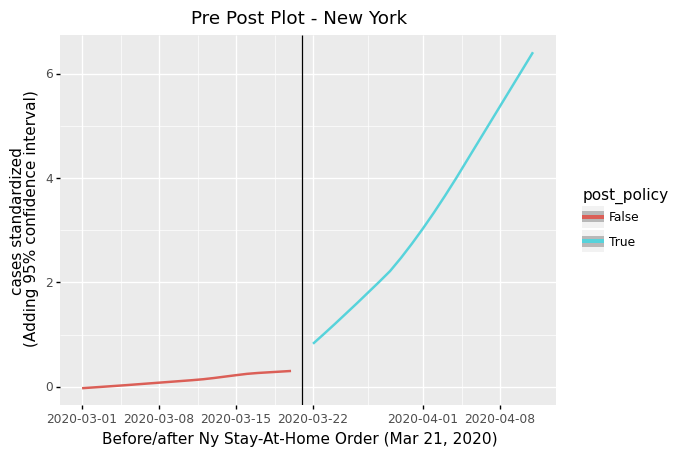

<ggplot: (8777054950241)>

In [11]:
(ggplot() +
    geom_smooth(merged_NY[merged_NY['date'] < '2020-03-21'],
                aes(x='date', y='cases_standardized', color='post_policy'), method='lowess') +
    geom_smooth(merged_NY[merged_NY['date'] > '2020-03-21'],
                aes(x='date', y='cases_standardized', color='post_policy'), method='lowess')
    + xlab('Before/after Ny Stay-At-Home Order (Mar 21, 2020)')
    + ylab(str("cases standardized") + ' \n(Adding 95% confidence interval)')
    + geom_vline(xintercept = '2020-03-21')
    + labs(title=str("Pre Post Plot - New York")))


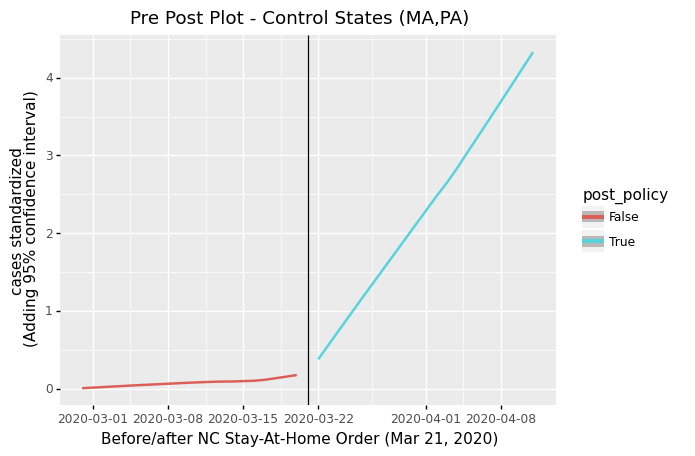

<ggplot: (8777054947609)>

In [12]:
# pre-post plot - control States (MA, PA, MD)
(ggplot() +
    geom_smooth(merged_control[merged_control['date'] < '2020-03-21'],
                aes(x='date', y='cases_standardized', color='post_policy'), method='lowess') +
    geom_smooth(merged_control[merged_control['date'] > '2020-03-21'],
                aes(x='date', y='cases_standardized', color='post_policy'), method='lowess')
    + xlab('Before/after NC Stay-At-Home Order (Mar 21, 2020)')
    + ylab(str("cases standardized") + ' \n(Adding 95% confidence interval)')
    + geom_vline(xintercept = '2020-03-21')
    + labs(title=str("Pre Post Plot - Control States (MA,PA)")))

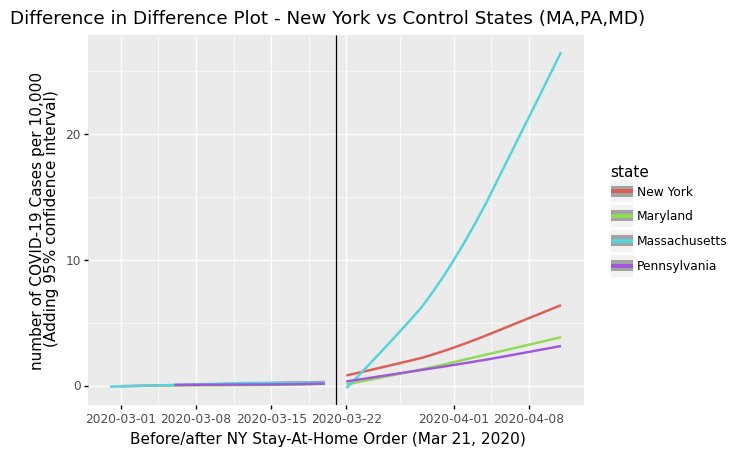

<ggplot: (8777055003061)>

In [13]:
# diff-in-diff plot - NY vs control States
(ggplot() +
    geom_smooth(merged_NY[merged_NY['date'] < '2020-03-21'],
                aes(x='date', y='cases_standardized', color='state'), method='lowess') +
    geom_smooth(merged_NY[merged_NY['date'] > '2020-03-21'],
                aes(x='date', y='cases_standardized', color='state'), method='lowess') +

    geom_smooth(merged_control[merged_control['date'] < '2020-03-21'],
                aes(x='date', y='cases_standardized', color='state'), method='lowess') +
    geom_smooth(merged_control[merged_control['date'] > '2020-03-21'],
                aes(x='date', y='cases_standardized', color='state'), method='lowess')
    + geom_vline(xintercept = '2020-03-21')
    + xlab('Before/after NY Stay-At-Home Order (Mar 21, 2020)')
    + ylab(str("number of COVID-19 Cases per 10,000") + ' \n(Adding 95% confidence interval)')
    + labs(title=str("Difference in Difference Plot - New York vs Control States (MA,PA,MD)")))


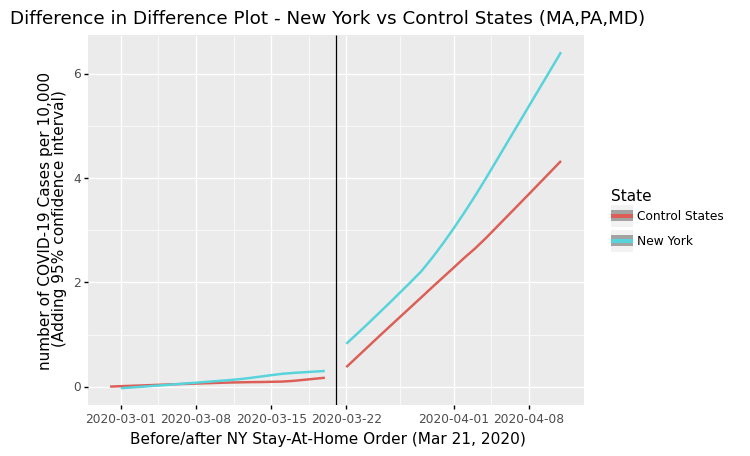

<ggplot: (8777056317151)>

In [14]:
# create indicator variable for treatment and control state
merged_NY['State'] = "New York"
merged_control['State'] = "Control States"

# diff-in-diff plot - NY vs control counties
(ggplot() +
    geom_smooth(merged_control[merged_control['date'] < '2020-03-21'],
                aes(x='date', y='cases_standardized', color='State'), method='lowess') +
    geom_smooth(merged_control[merged_control['date'] > '2020-03-21'],
                aes(x='date', y='cases_standardized', color='State'), method='lowess') +
    geom_smooth(merged_NY[merged_NY['date'] < '2020-03-21'],
                aes(x='date', y='cases_standardized', color='State'), method='lowess') +
    geom_smooth(merged_NY[merged_NY['date'] > '2020-03-21'],
                aes(x='date', y='cases_standardized', color='State'), method='lowess')
    + geom_vline(xintercept = '2020-03-21')
    + xlab('Before/after NY Stay-At-Home Order (Mar 21, 2020)')
    + ylab(str("number of COVID-19 Cases per 10,000") + ' \n(Adding 95% confidence interval)')
    + labs(title=str("Difference in Difference Plot - New York vs Control States (MA,PA,MD)")))